In [1]:
import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
from torch import nn as nn
from torch import optim as optim
from torch.utils import data as data
from torchvision import datasets as datasets
from torchvision import models as models
from torchvision import transforms as transforms
from tqdm.notebook import tqdm

In [2]:
data_transforms = {
    # 学習時の Transform
    "train": transforms.Compose(
        [
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    ),
    # 推論時の Transform
    "test": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    ),
}

# Dataset を作成する。
img_datasets = {
    x: datasets.STL10(
        root="/data", split=x, download=True, transform=data_transforms[x]
    )
    for x in ["train", "test"]
}

dataloaders = {
    x: data.DataLoader(img_datasets[x], batch_size=8, shuffle=True, num_workers=4)
    for x in ["train", "test"]
}

class_names = img_datasets["train"].classes
print(class_names)

def get_device(gpu_id=-1):
    if gpu_id >= 0 and torch.cuda.is_available():
        return torch.device("cuda", gpu_id)
    else:
        return torch.device("cpu")


device = get_device(gpu_id=0)

Files already downloaded and verified
Files already downloaded and verified
['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


### 学習用のヘルパー関数を作成する

In [3]:
def train(model, criterion, optimizer, scheduler, dataloaders, device, n_epochs):
    """指定したエポック数だけ学習する。
    """
    history = []
    for epoch in range(n_epochs):
        info = train_on_epoch(
            model, criterion, optimizer, scheduler, dataloaders, device
        )
        info["epoch"] = epoch + 1
        history.append(info)

        print(
            f"epoch {info['epoch']:<2} "
            f"[train] loss: {info['train_loss']:.6f}, accuracy: {info['train_accuracy']:.0%} "
            f"[test] loss: {info['test_loss']:.6f}, accuracy: {info['test_accuracy']:.0%}"
        )
    history = pd.DataFrame(history)

    return history

In [4]:
def train_on_epoch(model, criterion, optimizer, scheduler, dataloaders, device):
    """1エポックだけ学習する学習する。
    """
    info = {}
    for phase in ["train", "test"]:
        if phase == "train":
            model.train()  # モデルを学習モードに設定する。
        else:
            model.eval()  # モデルを推論モードに設定する。

        total_loss = 0
        total_correct = 0
        for inputs, labels in tqdm(dataloaders[phase]):
            # データ及びラベルを計算を実行するデバイスに転送する。
            inputs, labels = inputs.to(device), labels.to(device)

            # 学習時は勾配を計算するため、set_grad_enabled(True) で中間層の出力を記録するように設定する。
            with torch.set_grad_enabled(phase == "train"):
                # 順伝搬を行う。
                outputs = model(inputs)
                # 確率の最も高いクラスを予測ラベルとする。
                preds = outputs.argmax(dim=1)

                # 損失関数の値を計算する。
                loss = criterion(outputs, labels)

                if phase == "train":
                    # 逆伝搬を行う。
                    optimizer.zero_grad()
                    loss.backward()

                    # パラメータを更新する。
                    optimizer.step()

            # この反復の損失及び正答数を加算する。
            total_loss += float(loss)
            total_correct += int((preds == labels).sum())

        if phase == "train":
            # 学習率を調整する。
            scheduler.step()

        # 損失関数の値の平均及び精度を計算する。
        info[f"{phase}_loss"] = total_loss / len(dataloaders[phase].dataset)
        info[f"{phase}_accuracy"] = total_correct / len(dataloaders[phase].dataset)

    return info

### 損失関数と精度の履歴を描画するヘルパー関数を作成する

In [5]:
def plot_history(history):
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(8, 3))

    # 損失の推移
    ax1.set_title("Loss")
    ax1.plot(history["epoch"], history["train_loss"], label="train")
    ax1.plot(history["epoch"], history["test_loss"], label="test")
    ax1.set_xlabel("Epoch")
    ax1.legend()

    # 精度の推移
    ax2.set_title("Accuracy")
    ax2.plot(history["epoch"], history["train_accuracy"], label="train")
    ax2.plot(history["epoch"], history["test_accuracy"], label="test")
    ax2.set_xlabel("Epoch")
    ax2.legend()

    plt.show()

### Finetuning

In [6]:
# VGG16 を作成する。
model_ft = models.vgg16(pretrained=True)

# 出力層の出力数を ImageNet の 1000 からこのデータセットのクラス数である 2 に置き換える。
model_ft.classifier[-1] = nn.Linear(model_ft.classifier[-1].in_features, len(class_names))

# モデルを計算するデバイスに転送する。
model_ft = model_ft.to(device)

# 損失関数を作成する。
criterion = nn.CrossEntropyLoss()

# 最適化手法を選択する。
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

#### 学習する


epoch 1  [train] loss: 0.105451, accuracy: 71% [test] loss: 0.042326, accuracy: 89%



epoch 2  [train] loss: 0.081942, accuracy: 77% [test] loss: 0.048177, accuracy: 86%



epoch 3  [train] loss: 0.071663, accuracy: 80% [test] loss: 0.031576, accuracy: 91%



epoch 4  [train] loss: 0.064948, accuracy: 82% [test] loss: 0.031222, accuracy: 92%



epoch 5  [train] loss: 0.062010, accuracy: 83% [test] loss: 0.045780, accuracy: 88%



epoch 6  [train] loss: 0.059360, accuracy: 84% [test] loss: 0.027352, accuracy: 93%



epoch 7  [train] loss: 0.053153, accuracy: 85% [test] loss: 0.034533, accuracy: 91%



epoch 8  [train] loss: 0.037582, accuracy: 89% [test] loss: 0.019667, accuracy: 95%



epoch 9  [train] loss: 0.031326, accuracy: 91% [test] loss: 0.019027, accuracy: 95%



epoch 10 [train] loss: 0.030429, accuracy: 92% [test] loss: 0.018900, accuracy: 95%



epoch 11 [train] loss: 0.026940, accuracy: 92% [test] loss: 0.018684, accuracy: 95%



epoch 12 [train] loss: 0.028955, accuracy: 92% [test] loss: 0.018843, accuracy: 95%



epoch 13 [train] loss: 0.026771, accuracy: 92% [test] loss: 0.018686, accuracy: 95%



epoch 14 [train] loss: 0.026776, accuracy: 93% [test] loss: 0.018724, accuracy: 95%



epoch 15 [train] loss: 0.025948, accuracy: 93% [test] loss: 0.018165, accuracy: 96%



epoch 16 [train] loss: 0.025190, accuracy: 93% [test] loss: 0.017955, accuracy: 96%



epoch 17 [train] loss: 0.025676, accuracy: 93% [test] loss: 0.017911, accuracy: 96%



epoch 18 [train] loss: 0.026826, accuracy: 93% [test] loss: 0.017895, accuracy: 96%



epoch 19 [train] loss: 0.024733, accuracy: 93% [test] loss: 0.017864, accuracy: 96%



epoch 20 [train] loss: 0.023828, accuracy: 93% [test] loss: 0.017889, accuracy: 96%


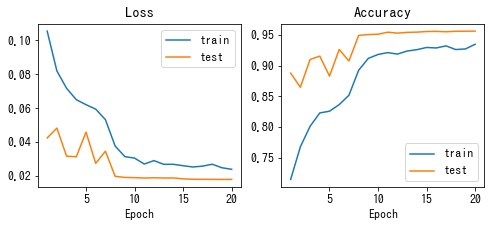

In [7]:
n_epochs = 20  # エポック数
history = train(
    model_ft, criterion, optimizer, scheduler, dataloaders, device, n_epochs
)

plot_history(history)